# Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle
from functools import partial

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [6]:
raw_data = pd.read_pickle('../data/dataset.pkl')

data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

### original label

In [7]:
def f(x):

    if x > 0.01:
        return 1
    elif x < -0.025:

        return -1
    

    else:
    
        return 0

In [8]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

# Use Optuna to find hyper-parameters for the training period 2001-01-01 to 2004-01-01

In [9]:
df_1 = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-01-01':'2004-04-01']
df_test = data.loc['2004-04-01':'2004-07-01']

In [10]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [11]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

In [12]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

### Using accuracy as Optuna objective

In [13]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy


In [26]:
study = optuna.create_study(direction="maximize")
from functools import partial

In [28]:
%%time
study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

CPU times: user 6min 47s, sys: 7.39 s, total: 6min 54s
Wall time: 48.4 s


In [29]:
study.best_params

{'max_depth': 3, 'n_estimators': 80, 'learning_rate': 0.5}

In [30]:
best_params_accuracy = {'n_estimators': 80, 'learning_rate': 0.5}

In [ ]:
#havne't run this but may use this

In [58]:
study.best_params

{'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.5}

In [59]:
best_params = {'n_estimators': 10, 'learning_rate': 0.5}

In [ ]:
#havne't run this but may use this

# Use the included 3 sets of optimal features over the holding period 2003-2018 and an AdaBoostClassifier

In [32]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [33]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [34]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [35]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [36]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [37]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [38]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [54]:
#fit in best hyper-params we found
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=10,learning_rate=0.5)

In [42]:
def adaboost_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

In [43]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = ada_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [44]:
import shap

In [45]:
shap_features = []

### 以下直接读pickle=========================================

## Using shap_features_ada

In [48]:
shap_features_00 = pd.read_pickle('shap_features_ada.pkl')

In [49]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data_00 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_00[i]].values),columns=shap_features_00[i]) for i in range(len(start_dates)-1)]
opt_valid_data_00 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_00[i]].values),columns=shap_features_00[i]) for i in range(len(start_dates)-1)]
opt_test_data_00 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_00[i]].values),columns=shap_features_00[i]) for i in range(len(start_dates)-1)]

In [50]:
opt_test_data_00[1]

,cfmq,epspi12,oeps12,curr_ratioq,market_cap,cfo-per-share,capeiq,fcf_yield,pe_incq,fcf_csfhdq,...,cf_yield,quick_ratioq,dpcq,epsx12,roceq,niq,oibdpy,psq,opmadq,accrualq
0,0.042424,-0.023103,-0.034056,0.884780,0.017999,-0.521710,0.007903,-0.198007,-0.039181,-0.217266,...,-0.642707,0.943761,-0.176471,-0.028186,-0.017654,-0.039094,-0.256591,-0.304201,0.030452,-0.248751
1,0.021683,-0.312222,-0.151559,-0.179459,-0.197034,0.173893,0.008470,-0.406912,-0.954300,-0.356346,...,2.737811,-0.086185,0.063208,-0.166539,-0.136048,-0.686419,0.548765,0.002336,0.025103,1.121090
2,0.017178,0.009852,-0.011540,0.019710,-0.223365,-0.185520,0.017206,-0.016963,0.077526,-0.111938,...,-0.108673,-0.317386,-0.155529,0.004788,0.088848,-0.092836,-0.108137,-0.077568,0.015394,-0.172940
3,0.022403,0.078479,0.077115,0.038191,-0.239567,-0.098114,0.027228,0.051241,0.278220,0.049499,...,-0.203505,-0.232305,-0.162772,0.073455,-0.045860,-0.020485,-0.184549,-0.146412,0.028256,-0.215148
4,0.041268,0.072364,0.048971,-0.188405,2.502370,-0.102260,0.019878,0.009106,0.269494,0.098515,...,-0.334669,-0.164772,0.295656,0.067336,0.151838,2.362718,1.790459,1.304738,0.035068,-0.051926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,0.022180,0.006455,-0.019983,-0.059389,0.110241,-0.312484,0.017299,-0.058058,0.064438,-0.144245,...,-0.278956,-0.240716,-0.060481,-0.008809,-0.043269,0.274932,-0.326916,0.281096,0.024758,-0.144176
1132,0.036278,0.049262,0.034899,-0.348417,-0.303815,-0.112439,0.016968,-0.032305,0.190962,0.077786,...,-0.387362,-0.246900,-0.185569,0.044221,0.031745,-0.126399,-0.281998,-0.336835,0.036009,-0.217807
1133,0.071111,-0.060134,-0.084716,0.247456,-0.140480,-0.302407,0.007877,-0.232850,-0.149345,-0.307842,...,0.400038,0.176708,0.327384,-0.065238,-0.110110,0.117461,-0.118103,-0.100724,0.016323,0.185487
1134,0.021718,0.034313,0.013790,0.317533,-0.341341,-0.303353,0.014460,-0.028351,0.134244,0.014379,...,-0.453907,0.439776,-0.203211,0.029263,0.199993,-0.141216,-0.306576,-0.351056,0.026387,-0.228920


In [ ]:
x_00 = [1]
ret_00 = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data_00[i],training_labels[i])

        preds_00 = ada_clf.predict(opt_test_data_00[i])
        profit_i_00 = (preds_00*test_frames[i]['next_period_return']).sum()
        ret_00.append(profit_i_00)
        num_names_00 = len(opt_test_data_00[i])
        x_00.append(x_00[i] + (x_00[i]/num_names_00)*profit_i_00)

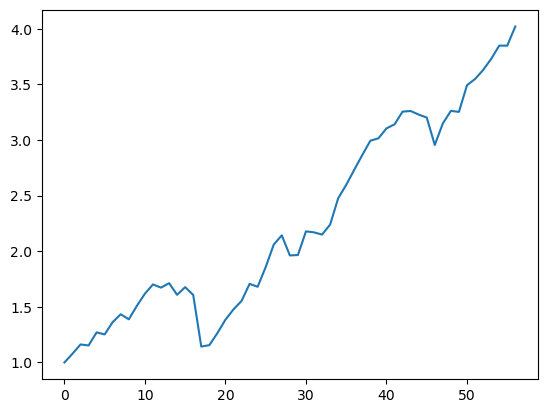

In [57]:
plt.plot(x_00);

## Using shap_features_ada_01

In [59]:
shap_features_01 = pd.read_pickle('shap_features_ada_01.pkl')

In [60]:
shap_features_01[10]

Index(['cf_yield', 'gpmq', 'oancfy_q', 'rect_turnq', 'roceq', 'dvpspq',
       'rectq', 'ibadj12', 'rd_saleq', 'spcsrc_C', 'gprofq',
       'book_value_per_share', 'piq', 'at_turnq', 'debt_assetsq', 'de_ratioq',
       'at4', 'epsfiq', 'cash_ratioq', 'opmbdq', 'cfo-per-share',
       'buy_back_yield', 'sector_code_395.0', 'evmq', 'dprq', 'sic_1311'],
      dtype='object')

In [61]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data_01 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_01[i]].values),columns=shap_features_01[i]) for i in range(len(start_dates)-1)]
opt_valid_data_01 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_01[i]].values),columns=shap_features_01[i]) for i in range(len(start_dates)-1)]
opt_test_data_01 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_01[i]].values),columns=shap_features_01[i]) for i in range(len(start_dates)-1)]

In [62]:
opt_test_data_01[1]

,fcf_yield,cf_yield,evmq,cash_conversionq,xsgay,roeq,oepf12,rd_saleq,ptpmq,dltry,...,capeiq,gprofq,yearly_sales,sector_code_300.0,fqtr_2,prccq,chechy,cfmq,fcf_csfhdq,pcfq
0,-0.198007,-0.642707,0.079080,0.161958,-0.267934,0.005448,-0.034950,-0.040516,0.037930,-0.220578,...,0.007903,0.006720,-0.323519,-0.152901,1.707184,1.018377,-0.541020,0.042424,-0.217266,0.122199
1,-0.406912,2.737811,-1.008394,0.156748,-0.337319,-0.019739,-0.148162,-0.090296,-0.015419,1.626170,...,0.008470,-0.842838,-0.026663,-0.152901,-0.585760,-1.033319,-0.284451,0.021683,-0.356346,-0.035955
2,-0.016963,-0.108673,0.015285,0.162378,0.345250,0.009155,-0.008932,-0.090296,0.027466,-0.220626,...,0.017206,2.259089,-0.104044,-0.152901,-0.585760,-0.313274,-0.063495,0.017178,-0.111938,-0.011194
3,0.051241,-0.203505,0.013118,0.214215,-0.198088,0.001531,0.069825,-0.090296,0.032890,-0.101919,...,0.027228,-0.226090,-0.170714,-0.152901,1.707184,0.093675,-0.107411,0.022403,0.049499,0.007315
4,0.009106,-0.334669,0.019836,0.137457,3.390534,0.025931,0.048026,-0.090296,0.047644,-0.132105,...,0.019878,1.476693,1.234606,-0.152901,-0.585760,0.562138,0.797786,0.041268,0.098515,-0.033265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,-0.058058,-0.278956,-0.004318,0.188685,0.083521,-0.013238,-0.015964,-0.090296,0.031551,-0.057849,...,0.017299,-0.132612,0.243293,-0.152901,1.707184,-0.289614,-0.407271,0.022180,-0.144245,-0.025578
1132,-0.032305,-0.387362,0.016386,0.149276,-0.263041,0.007314,0.032556,-0.090296,0.045412,-0.216128,...,0.016968,1.032005,-0.355123,-0.152901,1.707184,0.818846,-0.075637,0.036278,0.077786,0.162820
1133,-0.232850,0.400038,0.004571,0.180852,-0.211596,-0.006154,-0.084172,0.035477,0.027801,-0.149506,...,0.007877,0.323961,-0.126468,-0.152901,-0.585760,-0.919358,-0.288791,0.071111,-0.307842,-0.033820
1134,-0.028351,-0.453907,0.017270,0.159856,-0.308801,0.018620,0.009351,-0.090296,0.038785,-0.220626,...,0.014460,1.963101,-0.368895,-0.152901,1.707184,0.432404,-0.061401,0.021718,0.014379,0.356613


In [64]:
x_01 = [1]
ret_01 = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data_01[i],training_labels[i])

        preds_01 = ada_clf.predict(opt_test_data_01[i])
        profit_i_01 = (preds_01*test_frames[i]['next_period_return']).sum()
        ret_01.append(profit_i_01)
        num_names_01 = len(opt_test_data_01[i])
        x_01.append(x_01[i] + (x_01[i]/num_names_01)*profit_i_01)

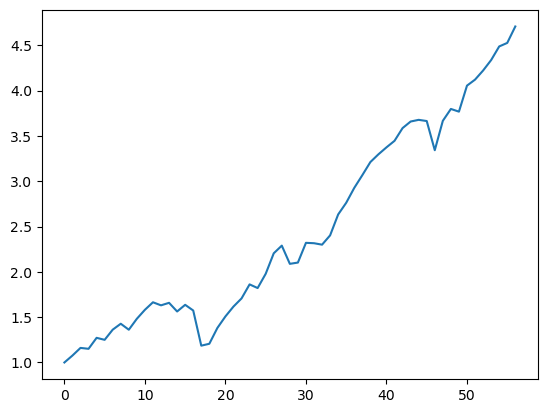

In [65]:
plt.plot(x_01);

## Using shap_features_ada_02

In [66]:
shap_features_02 = pd.read_pickle('shap_features_ada_02.pkl')

In [70]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data_02 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_02[i]].values),columns=shap_features_02[i]) for i in range(len(start_dates)-1)]
opt_valid_data_02 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_02[i]].values),columns=shap_features_02[i]) for i in range(len(start_dates)-1)]
opt_test_data_02 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_02[i]].values),columns=shap_features_02[i]) for i in range(len(start_dates)-1)]

In [71]:
opt_test_data_02[1]

,fcf_yield,cf_yield,evmq,cash_conversionq,xsgay,roeq,oepf12,rd_saleq,ptpmq,dltry,...,sector_code_440.0,apq,sale_nwcq,oibdpy,pe_op_dilq,epsfiq,oibdpq,cshoq,xidoy,opmadq
0,-0.198007,-0.642707,0.079080,0.161958,-0.267934,0.005448,-0.034950,-0.040516,0.037930,-0.220578,...,-0.065414,-0.156723,-0.009228,-0.256591,-0.097542,0.021062,-0.241703,-0.186967,0.075570,0.030452
1,-0.406912,2.737811,-1.008394,0.156748,-0.337319,-0.019739,-0.148162,-0.090296,-0.015419,1.626170,...,-0.065414,-0.093440,-0.002843,0.548765,-0.583731,-0.398602,-0.095685,0.368063,-5.663265,0.025103
2,-0.016963,-0.108673,0.015285,0.162378,0.345250,0.009155,-0.008932,-0.090296,0.027466,-0.220626,...,-0.065414,-0.141465,0.019888,-0.108137,0.014191,-0.034556,-0.239501,-0.212314,0.075570,0.015394
3,0.051241,-0.203505,0.013118,0.214215,-0.198088,0.001531,0.069825,-0.090296,0.032890,-0.101919,...,-0.065414,-0.145613,-0.000540,-0.184549,0.352410,0.187917,-0.140700,-0.286651,0.075570,0.028256
4,0.009106,-0.334669,0.019836,0.137457,3.390534,0.025931,0.048026,-0.090296,0.047644,-0.132105,...,-0.065414,0.015836,0.060936,1.790459,0.258796,0.238479,1.562906,1.685134,0.075570,0.035068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,-0.058058,-0.278956,-0.004318,0.188685,0.083521,-0.013238,-0.015964,-0.090296,0.031551,-0.057849,...,-0.065414,-0.121672,0.006343,-0.326916,-0.016007,0.071624,-0.336381,0.221718,0.315448,0.024758
1132,-0.032305,-0.387362,0.016386,0.149276,-0.263041,0.007314,0.032556,-0.090296,0.045412,-0.216128,...,-0.065414,-0.155985,-0.061273,-0.281998,0.192360,0.137355,-0.281563,-0.372983,0.075570,0.036009
1133,-0.232850,0.400038,0.004571,0.180852,-0.211596,-0.006154,-0.084172,0.035477,0.027801,-0.149506,...,-0.065414,-0.145444,-0.003445,-0.118103,-0.308929,-0.044668,0.173915,0.343712,0.075570,0.016323
1134,-0.028351,-0.453907,0.017270,0.159856,-0.308801,0.018620,0.009351,-0.090296,0.038785,-0.220626,...,-0.065414,-0.157856,0.013427,-0.306576,0.092706,0.152523,-0.307996,-0.391962,0.075570,0.026387


In [72]:
x_02 = [1]
ret_02 = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data_02[i],training_labels[i])

        preds_02 = ada_clf.predict(opt_test_data_02[i])
        profit_i_02 = (preds_02*test_frames[i]['next_period_return']).sum()
        ret_02.append(profit_i_02)
        num_names_02 = len(opt_test_data_02[i])
        x_02.append(x_02[i] + (x_02[i]/num_names_02)*profit_i_02)

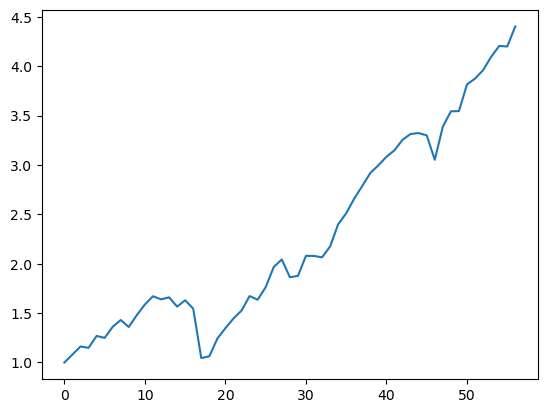

In [73]:
plt.plot(x_02);

# Three sets of shap_features preds different profits:
* x_00, x_01, x_02

In [77]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']#check if need to change
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy_00'] = x_00
SPY['strategy_01'] = x_01
SPY['strategy_02'] = x_02

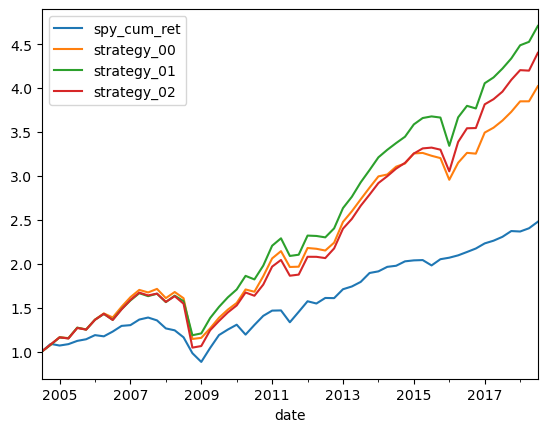

In [78]:
SPY.plot();

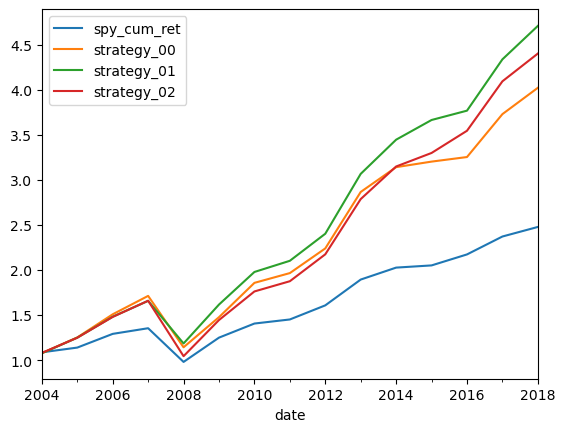

In [79]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [80]:
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [81]:
strategy_df = SPY.iloc[:,1:]

In [82]:
def summary_data(df_ret,spy_ret=spy_ret):
    strategy_mean_ret = (df_ret - 1).diff().mean()
    strategy_std = (df_ret - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    
    strategy_ret = (df_ret - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    
    alpha = np.mean(residual_ret)
    
    ending_cum_ret = df_ret[-1]
    
    return {'Sharpe ratio':strategy_sr,'beta':beta,'alpha':alpha,'IR':IR,'Strat_cum_ret( x[-1] )':ending_cum_ret}

In [83]:
summary_df = pd.DataFrame(columns=['Sharpe ratio','beta','alpha','IR','Strat_cum_ret( x[-1] )'],index=strategy_df.columns.T)

In [84]:
summary_df.loc['strategy_00']=summary_data(SPY['strategy_00'])
summary_df.loc['strategy_01']=summary_data(SPY['strategy_01'])
summary_df.loc['strategy_02']=summary_data(SPY['strategy_02'])

In [85]:
summary_df

,Sharpe ratio,beta,alpha,IR,Strat_cum_ret( x[-1] )
strategy_00,0.768349,1.772974,0.034125,0.386166,4.021425
strategy_01,0.973039,1.704836,0.090041,0.953026,4.707773
strategy_02,0.833611,1.891637,0.049297,0.70198,4.40123


In [86]:
def SharpeRatio(returns):
    strategy_mean_ret = (returns - 1).diff().mean()
    strategy_std = (returns - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    return strategy_sr

In [87]:
def beta(strat_ret,spy_ret=spy_ret):
    strategy_ret = (strat_ret - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    return beta

In [88]:
def InfoRatio(strat_ret,beta):
    strategy_ret = (strat_ret - 1).diff().values[1:]
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    return IR

In [89]:
def alpha(strat_ret,spy_ret=spy_ret):
    strategy_ret = (strat_ret - 1).diff().values[1:]
    residual_ret = strategy_ret - beta * spy_ret
    alpha = np.mean(residual_ret)
    return alpha

# Objective Using Max Drawdown ( failed so far

In [162]:
#return a positive number as the mdd
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [161]:
def objective_mdd(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    
    single_profit = preds * val_rets
    single_profit_df = single_profit.to_frame()
    daily_profit = single_profit_df.groupby(single_profit_df.index).sum()
    daily_returns = daily_profit.cumsum()
    mdd_val=max_drawdown(daily_returns.iloc[:,0])

 
    return mdd_val


In [163]:
study_mdd = optuna.create_study(direction="minimize")

In [164]:
%%time
study_mdd.optimize(partial(objective_mdd,train=train_1,labels=y_1,val=valid,val_labels=y_valid,\
                       val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)


CPU times: user 6min 40s, sys: 8.58 s, total: 6min 49s
Wall time: 48.4 s


In [165]:
study_mdd.best_params

{'max_depth': 3, 'n_estimators': 40, 'learning_rate': 0.4}